In [1]:
import imageio
import os
import pickle

import ccc
import torch
import utils

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import datetime, timedelta
from dateutil import rrule
from matplotlib.transforms import offset_copy
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef

/home/noxthot/anaconda3/envs/meteorology_verticallearning/lib/python3.7/site-packages/petastorm/spark/spark_dataset_converter.py:28: FutureWarning: pyarrow.LocalFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
  from pyarrow import LocalFileSystem


In [2]:
TARGET_MODE = 1
MODELDIR = "2022_02_21__11-11"

In [3]:
tmsubdir = f'targetmode_{TARGET_MODE}'
model_root_tm_path = os.path.join(ccc.MODEL_ROOT_PATH, tmsubdir)
    
modelpath = os.path.join(model_root_tm_path, MODELDIR)

with open(os.path.join(modelpath, 'train_monitor.pickle'), 'rb') as f:
    train_monitor = pickle.load(f)
    
opt_threshold, best_epoch = utils.getOptThresholdFromVal(train_monitor)

_, model_name = utils.load_model(os.path.join(tmsubdir, MODELDIR), torch.device("cpu"), best_epoch)

shap_path = os.path.join(modelpath, f"{model_name}_shap_parquet")

df_path = os.path.join(modelpath, f"{model_name}_test_df.pickle")

output_path = os.path.join(modelpath, f"{model_name}_plots_casestudy")

Loading model from ./data/models/targetmode_1/2022_02_21__11-11/_model_00018.pt


In [4]:
df_test = pd.read_pickle(df_path)

In [5]:
df_test.columns

Index(['output', 'target', 'longitude', 'latitude', 'hour', 'day', 'month',
       'year'],
      dtype='object')

In [6]:
#conversion to datetime
df_test["datetime"] = pd.to_datetime(df_test[['year', 'month', 'day', 'hour']])
df = df_test[["datetime", "latitude", "longitude", "target", "output", "day", "hour"]]
df.sort_values(by=['datetime'], ascending= True)
df = df.assign(category = "")

In [7]:
#column category
vc_threshold = utils.getVeryConfidentThreshold(opt_threshold)

df['category'] = np.select(
 [
    (df['output'] >= vc_threshold) & (df['target'] > 0.5),
    (df['output'] < vc_threshold) & (df['output'] >= opt_threshold) & (df['target'] > 0.5),
    (df['output'] < opt_threshold) & (df['target'] > 0.5),
    (df['output'] >= opt_threshold) & (df['target'] < 0.5),
    (df['output'] < opt_threshold) & (df['target'] < 0.5)
 ],
 [
    'TP_VC', # very confident true positive
    'TP_LC', # less confident true positive
    'FN',    # false negative
    'FP',    # false positive
    'TN'    # true negative
 ],
 default='ERROR'
)


In [8]:
#Neue Spalten anlegen: y_true, y_pred

df['y_true'] = df['target'].astype(np.int32)
df['y_pred'] = (df['output'] >= opt_threshold).astype(np.int32)
df

,datetime,latitude,longitude,target,output,day,hour,category,y_true,y_pred
0,2019-06-08 05:00:00,45.75,10.50,0.0,2.829107e-04,8,5,TN,0,0
1,2019-06-24 14:00:00,49.25,12.75,0.0,3.920528e-04,24,14,TN,0,0
2,2019-06-03 14:00:00,48.75,10.50,1.0,2.975281e-01,3,14,FN,1,0
3,2019-06-16 13:00:00,49.00,16.00,0.0,7.232859e-01,16,13,TN,0,0
4,2019-06-15 05:00:00,49.00,12.00,0.0,2.186375e-01,15,5,TN,0,0
...,...,...,...,...,...,...,...,...,...,...
1466320,2019-06-05 09:00:00,47.00,10.00,0.0,6.425114e-02,5,9,TN,0,0
1466321,2019-06-07 04:00:00,47.25,10.50,0.0,2.082612e-05,7,4,TN,0,0
1466322,2019-06-07 09:00:00,49.50,8.25,0.0,3.140145e-07,7,9,TN,0,0
1466323,2019-06-05 07:00:00,45.50,11.50,0.0,6.656502e-04,5,7,TN,0,0


In [9]:
longs = []
lats = []
mccs = []
f1scores = []

for long in np.unique(df.longitude):
    for lat in np.unique(df.latitude):
        
        test = df[(df.longitude == long) & (df.latitude == lat)]
        f1score= f1_score(test['y_true'], test['y_pred'])
        mcc = matthews_corrcoef(test['y_true'], test['y_pred'])
        mccs.append(mcc)
        f1scores.append(f1score)
        longs.append(long)
        lats.append(lat)
        
df_scores = pd.DataFrame({"longitude" : longs, "latitude" : lats, "mcc" : mccs, "f1score" : f1scores})


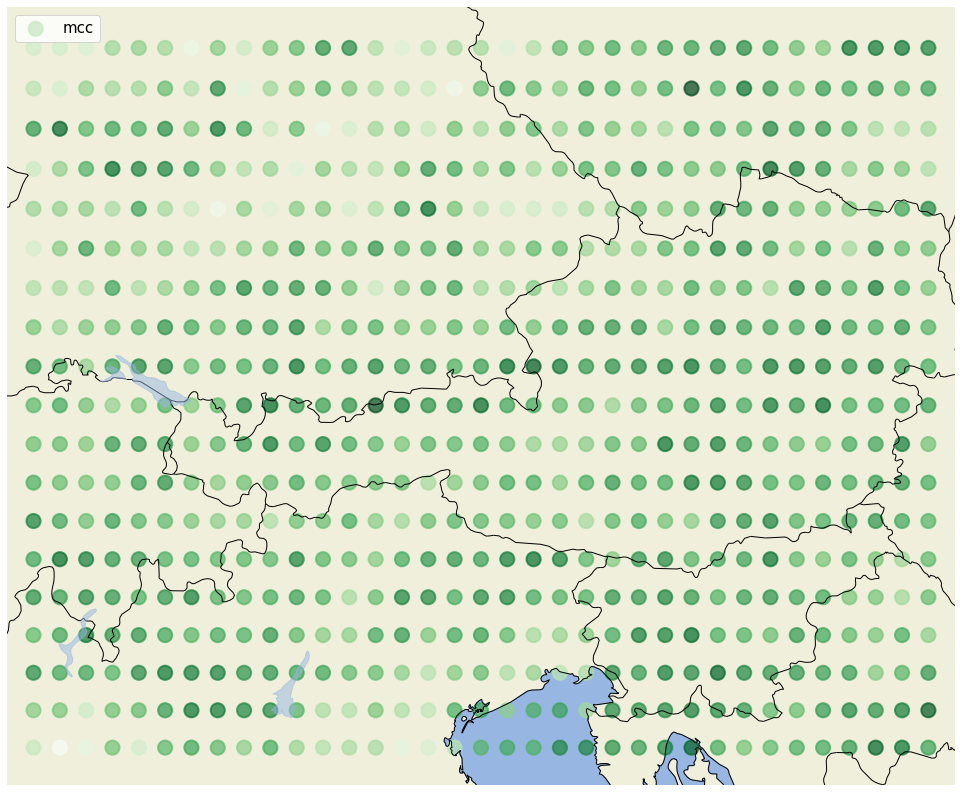

In [12]:
fig = plt.figure(figsize=(19.2, 10.8))

ax = plt.axes([0, 0, 1, 1], projection=ccrs.Mercator(), frameon=False)
ax.patch.set_visible(False)

ax.set_extent([8, 17, 45, 50], crs=ccrs.Geodetic())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle='-')
ax.add_feature(cfeature.LAKES, alpha=0.5)

ax.scatter(df_scores["longitude"], df_scores["latitude"], c=df_scores["mcc"], marker='.', s = 800, alpha=0.7, linewidth = 2, label='mcc', cmap="Greens", transform=ccrs.Geodetic())

ax.legend(loc=2, fontsize=15)
plt.show()

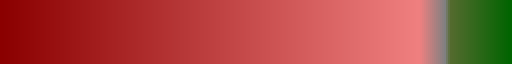

In [13]:
from matplotlib.colors import LinearSegmentedColormap

nodes = [0.0, opt_threshold - 0.05, opt_threshold, opt_threshold + 0.01, 1.0]
colors = ["darkred", "lightcoral", "grey", "darkolivegreen", "darkgreen"]
cmap1 = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))
cmap1

In [14]:
os.path.exists(output_path) or os.makedirs(output_path)

legend_TP_VC = mlines.Line2D([], [], marker="D", markersize=14, alpha=1, label='TP_VC', color="darkgreen", markeredgecolor='darkgreen', linewidth=2, linestyle='None')
legend_TP_LC = mlines.Line2D([], [], marker="D", markersize=12, alpha=0.95, color="darkolivegreen", label='TP_LC', linestyle='None')
legend_FN = mlines.Line2D([], [], marker="D", markersize=12, alpha=0.7, label='FN', color="lightcoral", markeredgecolor='darkred', linewidth=2, linestyle='None')
legend_FP = mlines.Line2D([], [], marker='.', markersize=12, alpha=0.7, label='FP', color="darkolivegreen", linestyle='None')

legend_elements = [legend_TP_VC, legend_TP_LC, legend_FN, legend_FP]

for specdate in np.unique(df_test.datetime.dt.date):
    for hour in range(24):
        date = datetime(specdate.year, specdate.month, specdate.day, hour)
        test = df[df.datetime == date]

        fig = plt.figure(figsize =(19.2, 10.8))
        ax.patch.set_visible(False)
        ax = plt.axes([0, 0, 1, 1], projection=ccrs.Mercator(), frameon=False)
        ax.patch.set_visible(False)
        ax.legend(handles=legend_elements, loc="upper left", fontsize=15)
               
        # Limit the extent of the map to a small longitude/latitude range.
        ax.set_extent([8, 17, 45, 50], crs=ccrs.Geodetic())

        TP_VC = test[test.category == "TP_VC"] 
        TP_LC = test[test.category == "TP_LC"]
        FN = test[test.category == "FN"]
        FP = test[test.category == "FP"]
        TN = test[test.category == "TN"]
        
        ax.scatter(TP_VC["longitude"], TP_VC["latitude"], c=TP_VC['output'], marker="D", s=200, alpha=1, edgecolor='darkgreen', linewidth=2, label='TP_VC', transform=ccrs.Geodetic(), cmap=cmap1, vmin=0, vmax=1)
        ax.scatter(TP_LC["longitude"], TP_LC["latitude"], c=TP_LC['output'], marker="D", s=150, alpha=0.95, label='TP_LC', linewidth=0, transform=ccrs.Geodetic(), cmap=cmap1, vmin=0, vmax=1)
        ax.scatter(FN["longitude"], FN["latitude"], c=FN['output'], marker="D", s=150, alpha=0.7, edgecolor='darkred', linewidth=2, label='FN', transform=ccrs.Geodetic(), cmap=cmap1, vmin=0, vmax=1)
        ax.scatter(FP["longitude"], FP["latitude"], c=FP['output'], marker='.', s=150, alpha=0.7, linewidth=0, label='FP', transform=ccrs.Geodetic(), cmap=cmap1, vmin=0, vmax=1)
        
        ax.add_feature(cfeature.LAND)
        ax.add_feature(cfeature.OCEAN)
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle='-')
        ax.add_feature(cfeature.LAKES, alpha=0.5)

        # Adding text
        # Positions for the date
        geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax)
        text_transform = offset_copy(geodetic_transform, units='dots')
        ax.text(16.8, 49.7, f"{date.strftime('%m/%d/%Y, %H:00')}",
                verticalalignment='center', horizontalalignment='right',transform=text_transform, fontsize = 20)
        fig.savefig(os.path.join(output_path, f"frame_{specdate}_{hour:02d}.png"), dpi= 100, facecolor='auto', bbox_inches='tight')
        ax.clear()

/home/noxthot/anaconda3/envs/meteorology_verticallearning/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


In [ ]:
#Animation
import os

images = []

for file_name in sorted(os.listdir(output_path)):
    if file_name.endswith('.png'):
        file_path = os.path.join(output_path, file_name)
        img = imageio.imread(file_path, pilmode="RGB")
        images.append(img)

In [ ]:
with imageio.get_writer(os.path.join(output_path, 'animation_fast.avi'), fps=24) as writer:
    for im in images:
        writer.append_data(im)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1335, 1100) to (1344, 1104) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x55bde65daec0] Warning: data is not aligned! This can lead to a speed loss
